# Tugas Besar Pembelajaran Mesin 2

#### Pustaka Terkait

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import datasets, metrics
import time
import random
import matplotlib.pyplot as plt
import math

In [2]:
iris = datasets.load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1)

In [3]:
train_data = [(x, y) for x, y in zip(X_train, y_train)]
test_data = [(x, y) for x, y in zip(X_test, y_test)]

## 1.a. Create a Classifier 

#### Deskripsi Algoritma

Inisialisasi model neural network ini menggunakan langkah-langkah sebagai berikut:
1. Jumlah node setiap layer (parameter sizes) dispesifikasikan.
2. Bias dan weight untuk setiap layer setelah layer pertama dihitung secara acak.

Proses fitting model sebelumnya menggunakan algoritma sebagai berikut:
1. Dalam fungsi fit dibutuhkan parameter jumlah data training (training_data), jumlah epoch (epochs), ukuran mini-batch (mini_batch_size), dan learning rate (learning_rate). Momentum (parameter momentum) jika diinginkan juga dapat dispesifikasikan. Data validasi (parameter validation_data) dapat dispesifikasikan secara langsung atau didapatkan dari training data jika parameter validation_split dispesifikasikan.
2. Training data dibagi-bagi menjadi mini-batch berdasarkan ukuran mini-batch.
3. Weight dan bias baru dihitung per mini-batch menggunakan fungsi update_mini_batch yang mengimplementasikan stochastic gradient. Dalam implementasi stochastic gradient digunakan fungsi backpropagation.
4. Lakukan langkah 3 untuk setiap mini-batch
5. Hitung akurasi dan loss training menggunakan fungsi evaluate dengan input mini-batch pertama. Fungsi evaluate menghasilkan nilai akurasi dan loss berdasarkan hasil feed-forward sigmoid (fungsi feed_forward). Hasil feed-forward setiap data jika lebih dari 0.5 akan menghasilkan 1, jika tidak menghasilkan 0. Akurasi dihitung dari rasio jumlah data setelah feed-forward yang sama dengan labelnya dengan jumlah seluruh data. Loss dihitung dari selisih kuadrat antara label dengan hasil data setelah feed-forward setiap data dibagi dengan jumlah semua data.
6. Hitung akurasi dan loss validasi menggunakan fungsi evaluate dengan input validation_data.
7. Lakukan langkah 2-6 untuk setiap epoch

Untuk melakukan prediksi dapat digunakan fungsi predict dengan input test_data. Dalam fungsi ini setiap test_data akan dilakukan feed-forward seperti pada fungsi evaluate.

#### Source Code Program

In [4]:
class Network(object):
    def __init__(self, sizes):
        self.sizes = sizes
        self.num_layers = len(sizes)
        self.biases = [np.random.rand(y, 1) for y in sizes[1:]]
        self.weights = [np.random.rand(y, x) for x,y in zip(sizes[:-1], sizes[1:])]
        self.history = d = {'acc': [], 'val_acc': [], 'loss': [], 'val_loss': []}
    
    def feed_forward(self, activation):
        for bias, weight in zip(self.biases, self.weights):
            activation = sigmoid(np.dot(weight, activation) + bias.transpose()[0])
        return activation
    
    def fit(self, training_data, epochs, mini_batch_size, learning_rate,
            momentum=0, validation_data=None, validation_split=0.0, verbose=1):
        if validation_split != 0.0 and not validation_data :
            training_data, validation_data = train_test_split(training_data, test_size=validation_split, random_state=42)
        n_training = len(training_data)
        if validation_data or validation_split != 0.0: 
            n_validation = len(validation_data)
            if verbose != 0:
                print("Train on {} samples, validate on {} samples".format(n_training, n_validation))
        for epoch in range(epochs):
            mini_batches = [training_data[k:k + mini_batch_size] for k in range(0, n_training, mini_batch_size)]
            previous_weights = self.weights
            previous_biases =self.biases
            first = True
            for mini_batch in mini_batches:
                if first: previous_weights, previous_biases = self.weights, self.biases
                start = time.time()
                previous_weights, previous_biases = self.update_mini_batch(mini_batch, 
                                                                           learning_rate,
                                                                           momentum, 
                                                                           previous_weights, 
                                                                           previous_biases)
                end = time.time() - start
            if validation_data or validation_split != 0:
                training_accuracy, training_loss = self.evaluate(mini_batches[0])
                validation_accuracy, validation_loss = self.evaluate(validation_data)
                self.history['acc'].append(training_accuracy)
                self.history['val_acc'].append(validation_accuracy)
                self.history['loss'].append(training_loss)
                self.history['val_loss'].append(validation_loss)
                if verbose == 1 :
                    print("Epoch {}/{} : {} s - loss: {} - acc: {} - val_loss: {} - val_acc: {}".format(epoch + 1, 
                                                                                                        epochs,
                                                                                                        end,
                                                                                                        training_loss,
                                                                                                        training_accuracy,
                                                                                                        validation_loss,
                                                                                                        validation_accuracy))
                elif verbose == 2 :
                    print("Epoch {} complete.".format(epoch + 1))
            else :
                if verbose != 0:
                    print("Epoch {} complete.".format(epoch + 1))
        
    def update_mini_batch(self, mini_batch, learning_rate, momentum, previous_weights, previous_biases):
        nabla_biases = [np.zeros(bias.shape) for bias in self.biases]
        nabla_weights = [np.zeros(weight.shape) for weight in self.weights]
        for x, y in mini_batch:
            delta_nabla_bias, delta_nabla_weights = self.backpropagation(x, y)
            nabla_biases = [nb + dnb for nb, dnb in zip(nabla_biases, delta_nabla_bias)]
            nabla_weights = [nw + dnw for nw, dnw in zip(nabla_weights, delta_nabla_weights)]
        temp_weights = self.weights
        temp_biases = self.biases
        self.weights = [w + momentum * pw + (learning_rate/len(mini_batch)) * nw 
                        for w, nw, pw in zip(self.weights, nabla_weights, previous_weights)]
        self.biases = [b + momentum * pb + (learning_rate/len(mini_batch)) * nb 
                       for b, nb, pb in zip(self.biases, nabla_biases, previous_biases)]
        return (temp_weights, temp_biases)
        
    def backpropagation(self, x, y):
        nabla_bias = [np.zeros(bias.shape) for bias in self.biases]
        nabla_weights = [np.zeros(weight.shape) for weight in self.weights]
        
        activation = x
        activations = [x]
        z_vectors = []
        
        for bias, weight in zip(self.biases, self.weights):
            z = np.dot(weight, activation) + bias.transpose()[0]
            z_vectors.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        
        delta = self.cost_derivative(activations[-1], y) * sigmoid_prime(z_vectors[-1])
        nabla_bias[-1] = delta
        delta_newaxis = delta[:, np.newaxis]
        m = len(activations[-2])
        activations_newaxis = activations[-2][:, np.newaxis].reshape(1, m)
        nabla_weights[-1] = np.dot(delta_newaxis, activations_newaxis)
        
        for layer in range(2, self.num_layers):
            z = z_vectors[-layer]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-layer+1].transpose(), delta) * sp
            nabla_bias[-layer] = delta
            delta_newaxis = delta[:, np.newaxis]
            m = len(activations[-layer-1].transpose())
            activations_newaxis = activations[-layer-1].transpose()[:, np.newaxis].reshape(1, m)
            nabla_weights[-layer] = np.dot(delta_newaxis, activations_newaxis)
        
        return (nabla_bias, nabla_weights)
    
    def evaluate(self, test_data):
        test_results = [(1 if self.feed_forward(x) * 2 >= 1 else 0, y) for x, y in test_data]
        accuracy = sum(int(x == y) for x, y in test_results)/len(test_results)
        loss = sum(math.pow((y - x), 2) for x, y in test_results)/len(test_results)
        return accuracy, loss
    
    def predict(self, test_data):
        test_results = [1 if self.feed_forward(x) * 2 >= 1 else 0 for x, y in test_data]
        return (test_results)
    
    def cost_derivative(self, output_activations, y):
        return np.squeeze(y - output_activations)

def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    return sigmoid(z)*(1-sigmoid(z))

#### Cara Pengunaan

In [5]:
neural_network = Network([4, 5, 10, 1])
neural_network.fit(train_data, 50, 5, 0.1, momentum=0.0001, validation_split=0.25, verbose=0)

Berikut adalah contoh penggunaan algoritma pada data latih iris. Namun, hasil tidak ditampilkan karena iris memiliki 3 label sedangkan classifier yang kami buat hanya biner. Untuk hasil classifier dapat dilihat pada bagian 1.b.2.

## 1.b.1 Explorasi Keras 

#### Deskripsi Algoritma

Pembelajaran akan menggunakan kakas keras dengan model <i>sequential</i> dan lapisan <i>dense</i> .Model akan memakai input layer sebanyak 1 neuron dengan bentuk input 4 sesuai jumlah attribute data latih, kemudian dengan 3 hidden layer masing-masing 2 neuron kemudian 3 neuron, dan 4 neuron dan 1 output layer dengan 1 neuron. Optimizer yang dipakai adalah SGD, dengan perhitungan loss dengan Mean Squared Error, dan Metrics Accuracy. 

#### Source Code Program

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Activation

Using TensorFlow backend.


In [7]:
network = Sequential()
network.add(Dense(1, activation='sigmoid', input_shape=(4,)))
network.add(Dense(2, activation='sigmoid'))
network.add(Dense(3, activation='sigmoid'))
network.add(Dense(1, activation='sigmoid'))

In [8]:
network.compile(optimizer='SGD', loss='mse', metrics=['accuracy'])

In [9]:
network.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 5         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 4         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 9         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 4         
Total params: 22
Trainable params: 22
Non-trainable params: 0
_________________________________________________________________


<b>Percobaan pada iris</b>

In [11]:
history = network.fit(X_train, y_train, epochs=200, verbose=0, batch_size=1, validation_split=0.1)

In [12]:
score = network.evaluate(X_test, y_test, batch_size=1)

15/15 [==============================] - 0s 414us/step


In [13]:
print("Loss: {} %".format(score[0]*100.0))
print("Accuracy {} %".format(score[1]*100.0))

Loss: 74.20312744972762 %
Accuracy 26.666666666666668 %


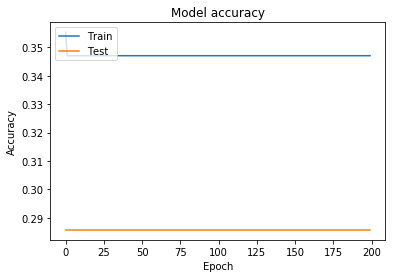

In [14]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

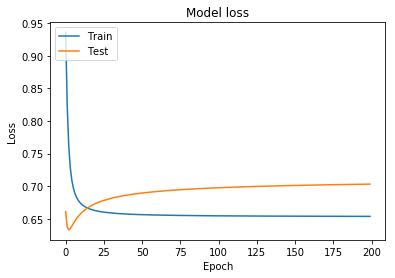

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## 1.b.2 Eksperimen Data Categorization Framework

### 1.b.2.1 Persiapan Data

Hal pertama yang kami lakukan adalah menggunakan data latih Weather Categorization dari WEKA. 

In [16]:
weather_df = pd.read_csv('dataset/weather.csv')

weather_df

,outlook,temperature,humidity,windy,play
0,sunny,85,85,False,no
1,sunny,80,90,True,no
2,overcast,83,86,False,yes
3,rainy,70,96,False,yes
4,rainy,68,80,False,yes
5,rainy,65,70,True,no
6,overcast,64,65,True,yes
7,sunny,72,95,False,no
8,sunny,69,70,False,yes
9,rainy,75,80,False,yes


Dapat dilihat data latih terdiri dari data numerik dan data kategorikal. Diperlukan preprocessing dengan kakas scikit-learn yaitu LabelEncoder sebagai berikut.

In [17]:
label_encoder = LabelEncoder()
weather_df['outlook'] = label_encoder.fit_transform(weather_df.outlook)
weather_df['windy'] = label_encoder.fit_transform(weather_df.windy)
weather_df['play'] = label_encoder.fit_transform(weather_df.play)

In [18]:
weather_df

,outlook,temperature,humidity,windy,play
0,2,85,85,0,0
1,2,80,90,1,0
2,0,83,86,0,1
3,1,70,96,0,1
4,1,68,80,0,1
5,1,65,70,1,0
6,0,64,65,1,1
7,2,72,95,0,0
8,2,69,70,0,1
9,1,75,80,0,1


In [19]:
X_weather = weather_df.iloc[:,:4].values
X_weather

array([[ 2, 85, 85,  0],
       [ 2, 80, 90,  1],
       [ 0, 83, 86,  0],
       [ 1, 70, 96,  0],
       [ 1, 68, 80,  0],
       [ 1, 65, 70,  1],
       [ 0, 64, 65,  1],
       [ 2, 72, 95,  0],
       [ 2, 69, 70,  0],
       [ 1, 75, 80,  0],
       [ 2, 75, 70,  1],
       [ 0, 72, 90,  1],
       [ 0, 81, 75,  0],
       [ 1, 71, 91,  1]])

In [20]:
y_weather = weather_df.play.values
y_weather

array([0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0])

Kemudian, setelah kami menjadikan data latih tersebut numerik, kami melakukan pemisahan sebagian data latih (10%) menjadi data uji dengan proporsi.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_weather, y_weather, test_size=0.1,shuffle=False)

In [22]:
X_train

array([[ 2, 85, 85,  0],
       [ 2, 80, 90,  1],
       [ 0, 83, 86,  0],
       [ 1, 70, 96,  0],
       [ 1, 68, 80,  0],
       [ 1, 65, 70,  1],
       [ 0, 64, 65,  1],
       [ 2, 72, 95,  0],
       [ 2, 69, 70,  0],
       [ 1, 75, 80,  0],
       [ 2, 75, 70,  1],
       [ 0, 72, 90,  1]])

In [23]:
X_test

array([[ 0, 81, 75,  0],
       [ 1, 71, 91,  1]])

In [24]:
y_train

array([0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1])

In [25]:
y_test

array([1, 0])

In [26]:
train_data = [(x, y) for x, y in zip(X_train, y_train)]
test_data = [(x, y) for x, y in zip(X_test, y_test)]

### 1.b.2.2 Batch = 1

#####  1.b.2.2.1 Classifier Sendiri

In [62]:
start = time.time()

In [63]:
neural_network1 = Network([4, 10, 8, 1])
neural_network1.fit(train_data, 100, 1, 0.1, validation_split=0.1)

Train on 10 samples, validate on 2 samples
Epoch 1/100 : 0.00012564659118652344 s - loss: 1.0 - acc: 0.0 - val_loss: 0.0 - val_acc: 1.0
Epoch 2/100 : 0.00011181831359863281 s - loss: 1.0 - acc: 0.0 - val_loss: 0.0 - val_acc: 1.0
Epoch 3/100 : 0.00012683868408203125 s - loss: 1.0 - acc: 0.0 - val_loss: 0.0 - val_acc: 1.0
Epoch 4/100 : 0.0001125335693359375 s - loss: 1.0 - acc: 0.0 - val_loss: 0.0 - val_acc: 1.0
Epoch 5/100 : 0.00011110305786132812 s - loss: 1.0 - acc: 0.0 - val_loss: 0.0 - val_acc: 1.0
Epoch 6/100 : 0.00011229515075683594 s - loss: 1.0 - acc: 0.0 - val_loss: 0.0 - val_acc: 1.0
Epoch 7/100 : 0.00011181831359863281 s - loss: 1.0 - acc: 0.0 - val_loss: 0.0 - val_acc: 1.0
Epoch 8/100 : 0.00012874603271484375 s - loss: 1.0 - acc: 0.0 - val_loss: 0.0 - val_acc: 1.0
Epoch 9/100 : 0.00012302398681640625 s - loss: 1.0 - acc: 0.0 - val_loss: 0.0 - val_acc: 1.0
Epoch 10/100 : 0.0001926422119140625 s - loss: 1.0 - acc: 0.0 - val_loss: 0.0 - val_acc: 1.0
Epoch 11/100 : 0.00017285346

In [64]:
end = time.time() - start

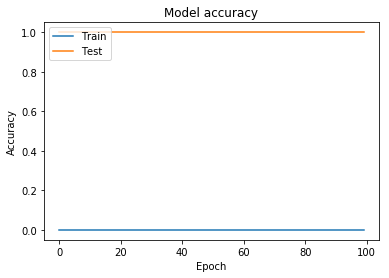

In [65]:
plt.plot(neural_network1.history['acc'])
plt.plot(neural_network1.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

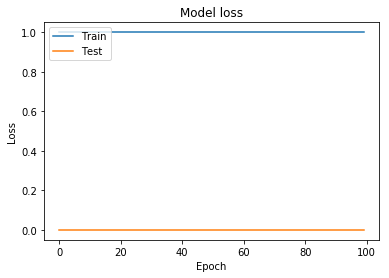

In [66]:
plt.plot(neural_network1.history['loss'])
plt.plot(neural_network1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [67]:
accuracy1, loss1 = neural_network1.evaluate(test_data)

In [68]:
print("Loss: {} %".format(loss1*100.0))
print("Accuracy {} %".format(accuracy1*100.0))
print("Time: {} ms".format(end))

Loss: 50.0 %
Accuracy 50.0 %
Time: 0.25215768814086914 ms


##### 1.b.2.2.2 Keras Model

Reinitialisasi model keras untuk eksperimen pertama.

In [69]:
network1 = Sequential([
    Dense(4, input_shape=(4,)),
    Dense(10, activation='sigmoid'),
    Dense(8, activation='sigmoid'),
    Dense(1, activation='sigmoid')
])

In [70]:
network1.compile(optimizer='SGD', loss='mse', metrics=['accuracy'])

In [71]:
network1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_14 (Dense)             (None, 10)                50        
_________________________________________________________________
dense_15 (Dense)             (None, 8)                 88        
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 9         
Total params: 167
Trainable params: 167
Non-trainable params: 0
_________________________________________________________________


In [72]:
start = time.time()

In [73]:
history1 = network1.fit(X_train, y_train, epochs=100, batch_size=1, validation_split=0.1)

Train on 10 samples, validate on 2 samples
Epoch 1/100
10/10 [==============================] - 0s 16ms/step - loss: 0.2793 - acc: 0.6000 - val_loss: 0.0424 - val_acc: 1.0000
Epoch 2/100
10/10 [==============================] - 0s 792us/step - loss: 0.2777 - acc: 0.6000 - val_loss: 0.0441 - val_acc: 1.0000
Epoch 3/100
10/10 [==============================] - 0s 792us/step - loss: 0.2761 - acc: 0.6000 - val_loss: 0.0458 - val_acc: 1.0000
Epoch 4/100
10/10 [==============================] - 0s 917us/step - loss: 0.2745 - acc: 0.6000 - val_loss: 0.0476 - val_acc: 1.0000
Epoch 5/100
10/10 [==============================] - 0s 924us/step - loss: 0.2729 - acc: 0.6000 - val_loss: 0.0494 - val_acc: 1.0000
Epoch 6/100
10/10 [==============================] - 0s 1ms/step - loss: 0.2714 - acc: 0.6000 - val_loss: 0.0513 - val_acc: 1.0000
Epoch 7/100
10/10 [==============================] - 0s 977us/step - loss: 0.2700 - acc: 0.6000 - val_loss: 0.0531 - val_acc: 1.0000
Epoch 8/100
10/10 [==========

10/10 [==============================] - 0s 909us/step - loss: 0.2411 - acc: 0.6000 - val_loss: 0.1397 - val_acc: 1.0000
Epoch 63/100
10/10 [==============================] - 0s 1ms/step - loss: 0.2410 - acc: 0.6000 - val_loss: 0.1404 - val_acc: 1.0000
Epoch 64/100
10/10 [==============================] - 0s 895us/step - loss: 0.2410 - acc: 0.6000 - val_loss: 0.1410 - val_acc: 1.0000
Epoch 65/100
10/10 [==============================] - 0s 920us/step - loss: 0.2409 - acc: 0.6000 - val_loss: 0.1417 - val_acc: 1.0000
Epoch 66/100
10/10 [==============================] - 0s 936us/step - loss: 0.2409 - acc: 0.6000 - val_loss: 0.1423 - val_acc: 1.0000
Epoch 67/100
10/10 [==============================] - 0s 952us/step - loss: 0.2408 - acc: 0.6000 - val_loss: 0.1430 - val_acc: 1.0000
Epoch 68/100
10/10 [==============================] - 0s 1ms/step - loss: 0.2408 - acc: 0.6000 - val_loss: 0.1435 - val_acc: 1.0000
Epoch 69/100
10/10 [==============================] - 0s 1ms/step - loss: 0.240

In [74]:
end = time.time() - start

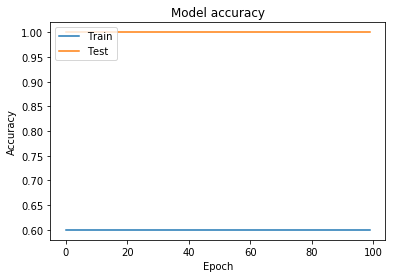

In [75]:
plt.plot(history1.history['acc'])
plt.plot(history1.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

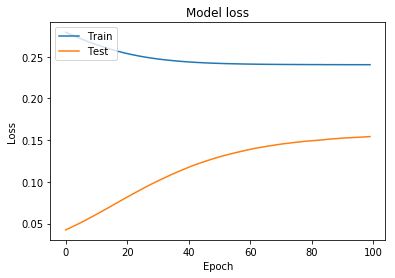

In [76]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [77]:
score1 = network1.evaluate(X_test, y_test, batch_size=1)

2/2 [==============================] - 0s 1ms/step


In [78]:
print("Loss: {} %".format(score1[0]*100.0))
print("Accuracy {} %".format(score1[1]*100.0))
print("Time: {} ms".format(end))

Loss: 25.379618257284164 %
Accuracy 50.0 %
Time: 1.3729908466339111 ms


### 1.b.2.3 Batch =  Jumlah Data Latih

##### 1.b.2.3.1 Classifier Sendiri

In [79]:
start = time.time()

In [80]:
neural_network2 = Network([4, 1])
neural_network2.fit(train_data, 100, len(X_train), 0.1, validation_split=0.1)

Train on 10 samples, validate on 2 samples
Epoch 1/100 : 0.0007219314575195312 s - loss: 0.4 - acc: 0.6 - val_loss: 0.0 - val_acc: 1.0
Epoch 2/100 : 0.0004329681396484375 s - loss: 0.4 - acc: 0.6 - val_loss: 0.0 - val_acc: 1.0
Epoch 3/100 : 0.0004138946533203125 s - loss: 0.4 - acc: 0.6 - val_loss: 0.0 - val_acc: 1.0
Epoch 4/100 : 0.0003635883331298828 s - loss: 0.4 - acc: 0.6 - val_loss: 0.0 - val_acc: 1.0
Epoch 5/100 : 0.00034046173095703125 s - loss: 0.4 - acc: 0.6 - val_loss: 0.0 - val_acc: 1.0
Epoch 6/100 : 0.0003230571746826172 s - loss: 0.4 - acc: 0.6 - val_loss: 0.0 - val_acc: 1.0
Epoch 7/100 : 0.0003504753112792969 s - loss: 0.4 - acc: 0.6 - val_loss: 0.0 - val_acc: 1.0
Epoch 8/100 : 0.0003190040588378906 s - loss: 0.4 - acc: 0.6 - val_loss: 0.0 - val_acc: 1.0
Epoch 9/100 : 0.00032329559326171875 s - loss: 0.4 - acc: 0.6 - val_loss: 0.0 - val_acc: 1.0
Epoch 10/100 : 0.0003185272216796875 s - loss: 0.4 - acc: 0.6 - val_loss: 0.0 - val_acc: 1.0
Epoch 11/100 : 0.00031685829162597

Epoch 90/100 : 0.0003173351287841797 s - loss: 0.4 - acc: 0.6 - val_loss: 0.0 - val_acc: 1.0
Epoch 91/100 : 0.00041031837463378906 s - loss: 0.4 - acc: 0.6 - val_loss: 0.0 - val_acc: 1.0
Epoch 92/100 : 0.0003485679626464844 s - loss: 0.4 - acc: 0.6 - val_loss: 0.0 - val_acc: 1.0
Epoch 93/100 : 0.0003197193145751953 s - loss: 0.4 - acc: 0.6 - val_loss: 0.0 - val_acc: 1.0
Epoch 94/100 : 0.00032210350036621094 s - loss: 0.4 - acc: 0.6 - val_loss: 0.0 - val_acc: 1.0
Epoch 95/100 : 0.00035881996154785156 s - loss: 0.4 - acc: 0.6 - val_loss: 0.0 - val_acc: 1.0
Epoch 96/100 : 0.00036525726318359375 s - loss: 0.4 - acc: 0.6 - val_loss: 0.0 - val_acc: 1.0
Epoch 97/100 : 0.0003197193145751953 s - loss: 0.4 - acc: 0.6 - val_loss: 0.0 - val_acc: 1.0
Epoch 98/100 : 0.00031566619873046875 s - loss: 0.4 - acc: 0.6 - val_loss: 0.0 - val_acc: 1.0
Epoch 99/100 : 0.00034809112548828125 s - loss: 0.4 - acc: 0.6 - val_loss: 0.0 - val_acc: 1.0
Epoch 100/100 : 0.00031828880310058594 s - loss: 0.4 - acc: 0.6 

In [81]:
end = time.time() - start

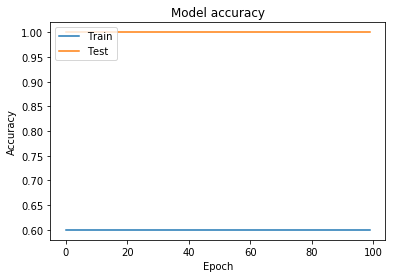

In [82]:
plt.plot(neural_network2.history['acc'])
plt.plot(neural_network2.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

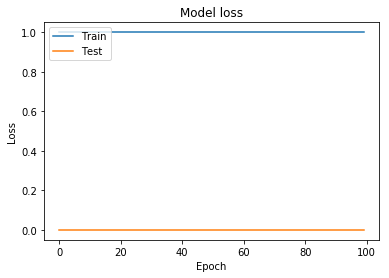

In [83]:
plt.plot(neural_network1.history['loss'])
plt.plot(neural_network1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [84]:
accuracy2, loss2 = neural_network2.evaluate(test_data)

In [85]:
print("Loss: {} %".format(loss2*100.0))
print("Accuracy {} %".format(accuracy2*100.0))
print("Time: {} ms".format(end))

Loss: 50.0 %
Accuracy 50.0 %
Time: 0.15543508529663086 ms


##### 1.b.2.3.2 Keras Model

Reinitialisasi model keras untuk eksperimen kedua.

In [86]:
network2 = Sequential([
    Dense(4, input_shape=(4,)),
    Dense(10, activation='sigmoid'),
    Dense(8, activation='sigmoid'),
    Dense(1, activation='sigmoid')
])

In [87]:
network2.compile(optimizer='SGD', loss='mse', metrics=['accuracy'])

In [88]:
network2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_18 (Dense)             (None, 10)                50        
_________________________________________________________________
dense_19 (Dense)             (None, 8)                 88        
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 9         
Total params: 167
Trainable params: 167
Non-trainable params: 0
_________________________________________________________________


In [89]:
start = time.time()

In [90]:
history2 = network2.fit(X_train, y_train, epochs=100, batch_size=len(X_train), validation_split=0.1)

Train on 10 samples, validate on 2 samples
Epoch 1/100
10/10 [==============================] - 0s 16ms/step - loss: 0.3501 - acc: 0.4000 - val_loss: 0.5346 - val_acc: 0.0000e+00
Epoch 2/100
10/10 [==============================] - 0s 179us/step - loss: 0.3494 - acc: 0.4000 - val_loss: 0.5331 - val_acc: 0.0000e+00
Epoch 3/100
10/10 [==============================] - 0s 157us/step - loss: 0.3488 - acc: 0.4000 - val_loss: 0.5316 - val_acc: 0.0000e+00
Epoch 4/100
10/10 [==============================] - 0s 144us/step - loss: 0.3481 - acc: 0.4000 - val_loss: 0.5302 - val_acc: 0.0000e+00
Epoch 5/100
10/10 [==============================] - 0s 147us/step - loss: 0.3474 - acc: 0.4000 - val_loss: 0.5287 - val_acc: 0.0000e+00
Epoch 6/100
10/10 [==============================] - 0s 154us/step - loss: 0.3468 - acc: 0.4000 - val_loss: 0.5272 - val_acc: 0.0000e+00
Epoch 7/100
10/10 [==============================] - 0s 141us/step - loss: 0.3461 - acc: 0.4000 - val_loss: 0.5257 - val_acc: 0.0000e+00

Epoch 61/100
10/10 [==============================] - 0s 158us/step - loss: 0.3129 - acc: 0.4000 - val_loss: 0.4482 - val_acc: 0.0000e+00
Epoch 62/100
10/10 [==============================] - 0s 143us/step - loss: 0.3124 - acc: 0.4000 - val_loss: 0.4469 - val_acc: 0.0000e+00
Epoch 63/100
10/10 [==============================] - 0s 115us/step - loss: 0.3118 - acc: 0.4000 - val_loss: 0.4455 - val_acc: 0.0000e+00
Epoch 64/100
10/10 [==============================] - 0s 121us/step - loss: 0.3113 - acc: 0.4000 - val_loss: 0.4441 - val_acc: 0.0000e+00
Epoch 65/100
10/10 [==============================] - 0s 172us/step - loss: 0.3107 - acc: 0.4000 - val_loss: 0.4428 - val_acc: 0.0000e+00
Epoch 66/100
10/10 [==============================] - 0s 126us/step - loss: 0.3102 - acc: 0.4000 - val_loss: 0.4414 - val_acc: 0.0000e+00
Epoch 67/100
10/10 [==============================] - 0s 144us/step - loss: 0.3096 - acc: 0.4000 - val_loss: 0.4400 - val_acc: 0.0000e+00
Epoch 68/100
10/10 [==============

In [91]:
end = time.time() - start

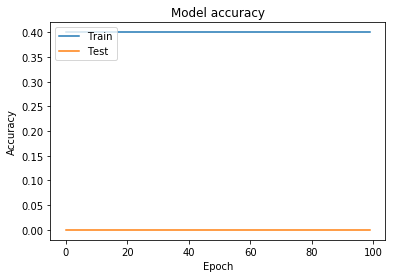

In [92]:
plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

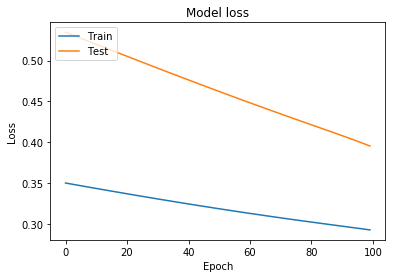

In [93]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [94]:
score2 = network2.evaluate(X_test, y_test, batch_size=len(X_train))

2/2 [==============================] - 0s 381us/step


In [95]:
print("Loss: {} %".format(score2[0]*100.0))
print("Accuracy {} %".format(score2[1]*100.0))
print("Time: {} ms".format(end))

Loss: 26.761144399642944 %
Accuracy 50.0 %
Time: 0.5860557556152344 ms


### 1.b.2.4 Analisis Eksperimen

Berdasarkan hasil eksperimen dengan classifier sendiri dan model keras, dapat disimpulkan dengan tabel berikut ini.

In [112]:
pd.DataFrame({'Classifier' : ['Classifier Sendiri', 'Keras Model', 'Classifier Sendiri', 'Keras Model'],
              'Batch' : [1, len(X_train), 1, len(X_train)],
              'Loss' :[loss1, score1[0], loss2, score2[0]],
              'Accuracy' :[accuracy1, score1[1], accuracy2, score2[1]]})

,Classifier,Batch,Loss,Accuracy
0,Classifier Sendiri,1,0.500000,0.5
1,Keras Model,12,0.253796,0.5
2,Classifier Sendiri,1,0.500000,0.5
3,Keras Model,12,0.267611,0.5


Akurasi yang dihasilkan dari kedua classifier adalah sama. Namun, jika melihat grafik dari akurasi dan loss, terlihat bahwa classifier 4 menghasilkan model yang lebih baik dari yang lain.

### Pembagian Kerja